## Data set 2: railway stations equipment for disabled people



Source and documentation:
http://data.sbb.ch/explore/dataset/equipement/


1. Open your dataset up using pandas in a Jupyter notebook
2. Do a .head() to get a feel for your data
3. Write down 12 questions to ask your data, or 12 things to hunt for in the data
4. Attempt to answer those ten questions using the magic of pandas
5. Make three charts with your dataset
6. Keep track of anything that was problematic - it can be non-standard country names, extra spaces in columns, trouble getting multiple colors in scatterplots, whatever you'd like.


In [52]:
import pandas as pd

In [22]:
df = pd.read_csv("stations.csv", delimiter=';')

In [23]:
df.head(5)

,didok,station_name,accessible_ticket,accessible_wc,wheelchair_load,mobilift,stepless_perron,bats,autelca,automat_ktu,geopos,TUNummer,Betriebspunkttyp
0,10,Basel SBB,1.0,1.0,1.0,1.0,1.0,10 Min. Übergangszeit für Züge von und nach Fr...,0.0,19.0,"47.5474041527, 7.58955146721",1,Haltestelle
1,2213,Wohlen,1.0,1.0,1.0,1.0,1.0,NaN,0.0,2.0,"47.3484618374, 8.26978121872",1,Haltestelle_und_Bedienpunkt
2,2116,Schinznach Bad,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,"47.4517752695, 8.16692832223",1,Haltestelle
3,2211,Hendschiken,1.0,0.0,1.0,0.0,0.0,NaN,0.0,1.0,"47.3894242237, 8.20737399629",1,Haltestelle
4,2226,Knonau,0.0,0.0,0.0,1.0,1.0,NaN,0.0,1.0,"47.2202591199, 8.4667085831",1,Haltestelle


In [24]:
print("Q1: How many train station is there in Switzerland? How many of them are accessible for wheelchairs?")

accessible_perron = df[df['stepless_perron'] == 1]

print("A: There is", df.shape[0], "stations.", accessible_perron.shape[0], "of them have a stepless perron.")
#df.describe()
#df['accessible_ticket'].value_counts()

Q1: How many train station is there in Switzerland? How many of them are accessible for wheelchairs?
A: There is 731 stations. 460 of them have a stepless perron.


In [25]:
import math
print("Q2: What does “bats” stand for? Is there interesting data about that?")

print("A: This field contains comments in french, italian and german about the stations.")

print("The metadata says: “Comment field (Billet Automat Touch Screen?)” with a question mark.")

bats = df[df['bats'] == df['bats']] # check if equals to himself to get rid of the NaN
#bats[['station_name','bats']].head(5) # to explore the data

print("Some stations are marked as “not served” in french. The “bats” column enables us to get a non-extensive list of these:")

bats[bats['bats'] == 'non desservi'][['station_name','bats']]


Q2: What does “bats” stand for? Is there interesting data about that?
A: This field contains comments in french, italian and german about the stations.
The metadata says: “Comment field (Billet Automat Touch Screen?)” with a question mark.
Some stations are marked as “not served” in french. The “bats” column enables us to get a non-extensive list of these:


,station_name,bats
54,"Evouettes, Les",non desservi
147,Vouvry,non desservi
333,Collombey,non desservi
334,Vionnaz,non desservi
335,St-Gingolph (Suisse),non desservi
421,Bouveret,non desservi


In [26]:
print("Q3: How many stations offer help to board and get out of the trains? What percentage of the stations does it represent?")
with_help = df['wheelchair_load'].value_counts()[1]
total = with_help + df['wheelchair_load'].value_counts()[0]
percentage = (with_help*100) / total
print("A:", with_help, "stations offer help to board and get out of trains. This represents", "%.2f" % percentage + "% of the total.")


Q3: How many stations offer help to board and get out of the trains? What percentage of the stations does it represent?
A: 193 stations offer help to board and get out of trains. This represents 27.03% of the total.


In [27]:
print("Q4: Which are the 10 least equipped stations?")

# For our rating, we just want to know if “automat_ktu” is more than 1, and not add the actual number.
def automat(x):
    if x > 0:
        return 1
    else:
        return 0

df['rating'] = df['accessible_ticket'] + df['accessible_wc'] + df['wheelchair_load'] + df['mobilift'] + df['stepless_perron'] + df['autelca'] + df['automat_ktu'].apply(automat)

zeroRatingCount = df['didok'][df['rating'] == 0].count()

print("A: These 10 stations have zero recorded equipment. But", zeroRatingCount-10, "other station have no equipment.")


df[['station_name', 'rating']].sort_values(by='rating').head(10)

Q4: Which are the 10 least equipped stations?
A: These 10 stations have zero recorded equipment. But 33 other station have no equipment.


,station_name,rating
98,"Deurres, Les",0.0
589,Kerzers Papiliorama,0.0
114,Kölliken Oberdorf,0.0
606,Schloss Laufen am Rheinfall,0.0
408,"Tuileries, Les",0.0
293,Grandson,0.0
462,Mühlau,0.0
465,Chamoson,0.0
710,Worb SBB,0.0
119,Rekingen AG,0.0


In [28]:
print('Q5: Is there areas with a lot of non-equipped stations?')

zeroRating = df[df['rating'] == 0]
# posList = df['geopos'].tolist
geopos_array = []
neighbors_list = []

# 1) store all positions in an array
for index, row in zeroRating.iterrows():
    geopos = row['geopos'].split(', ')
    latlng = [float(item) for item in geopos]
    geopos_array.append(latlng)
    neighbors_list.append(row['station_name'])

# 2) store “neighbour” non-equipped stations in two new columns

# [latitude = 47.452833265 N, longitude = 8.70557069755 E]
# In Switzerland, 1 ~= 110 km for latitude, 75 km for longitude
# Let's say 50 km is enough to be "neighbour" stations (31 miles, a bit more than Columbia University - Newark)
# It's a rough calculation: the surface in which cities are "neighbour" is a square and not a circle.
latdistance = 0.4
longdistance = 0.6

df['neighbors_unequipped'] = 0
df['neighbors_names'] = ''

for index, row in zeroRating.iterrows(): # iteration 1: through the stations
    neighbors_count = 0
    neighbors_index = 0
    neighbors_currlist = []
    geopos = row['geopos'].split(', ')
    latlng = [float(item) for item in geopos]
    
    for loc in geopos_array: # iteration 2: through the array of locations
        if loc != latlng: # we check if this isn't the current station location
            if (abs(loc[0] - latlng[0]) < latdistance) and (abs(loc[1] - latlng[1]) < longdistance):
                neighbors_count += 1
                neighbors_currlist.append(neighbors_list[neighbors_index])
        neighbors_index += 1

    df.loc[index, 'neighbors_unequipped'] = neighbors_count
    df.loc[index, 'neighbors_names'] = str.join(', ', neighbors_currlist)

df[df['neighbors_unequipped'] > 0].sort_values(by='neighbors_unequipped', ascending=False).head(10)

top_unequipped = df[df['neighbors_unequipped'] > 0].sort_values(by='neighbors_unequipped', ascending=False)


print("[We create two new columns and get this list -- text answer in the next cell]")
top_unequipped[['station_name', 'neighbors_unequipped', 'neighbors_names']].head(10)



Q5: Is there areas with a lot of non-equipped stations?
[We create two new columns and get this list -- text answer in the next cell]


,station_name,neighbors_unequipped,neighbors_names
543,Baldegg Kloster,16,"Kemptthal, Blumenau, Walterswil-Striegel, Köll..."
351,Küngoldingen,15,"Walterswil-Striegel, Kölliken Oberdorf, Reking..."
671,Emmenmatt,15,"Suberg-Grossaffoltern, Walterswil-Striegel, Kö..."
201,Trimbach,14,"Suberg-Grossaffoltern, Walterswil-Striegel, Kö..."
674,Littau,14,"Kemptthal, Blumenau, Walterswil-Striegel, Köll..."
114,Kölliken Oberdorf,14,"Walterswil-Striegel, Rekingen AG, Rothenburg, ..."
635,Lyssach,14,"Suberg-Grossaffoltern, Walterswil-Striegel, Kö..."
158,Rothenburg,14,"Kemptthal, Blumenau, Walterswil-Striegel, Köll..."
236,Olten Hammer,14,"Suberg-Grossaffoltern, Walterswil-Striegel, Kö..."
595,Signau,13,"Suberg-Grossaffoltern, Rothenburg, Brügg BE, K..."


In [29]:
# 3) new for loop to get a “clean” list of different locations,
# which means we avoid printing two stations from the same area

name_list = []
reject_list = []

for index, row in top_unequipped.iterrows(): # iteration 1: through the stations
    rejects = row['neighbors_names'] # we want to get the different areas
    reject_list.extend(rejects.split(', '))
    if row['station_name'] not in reject_list:
        name_list.append("“" + row['station_name'] + "”: " + str(row['neighbors_unequipped']))

print("Answer to Q5: These places count the most unequipped stations within about 50 km:", str.join(', ', name_list))

Answer to Q5: These places count the most unequipped stations within about 50 km: “Baldegg Kloster”: 16, “Deurres, Les”: 9, “Quartino”: 4, “Creux-de-Genthod”: 1, “Tuileries, Les”: 1


In [30]:
print("Q6: What is the average station “rating”, based on the number of equipments?")
print("A: The average rating is", df['rating'].mean())

Q6: What is the average station “rating”, based on the number of equipments?
A: The average rating is 2.32112676056


In [39]:
print("Q7: Merge this data with the passenger frequence. Is it a perfect match?")
dfp = pd.read_csv('passagierfrequenz.csv', delimiter=';')
dfm = df.merge(dfp, how='inner', left_on='station_name', right_on='Station')

print("A: It isn’t a perfect match. The “equipment” dataset has", df.shape[0], "rows; the “frequency” dataset has", dfp.shape[0], "rows; the merged dataset has only", dfm.shape[0], "rows.")
print("Here is the merged dataset:")

dfm


Q7: Merge this data with the passenger frequence. Is it a perfect match?
A: It isn’t a perfect match. The “equipment” dataset has 731 rows; the “frequency” dataset has 724 rows; the merged dataset has only 646 rows.
Here is the merged dataset:


,didok,station_name,accessible_ticket,accessible_wc,wheelchair_load,mobilift,stepless_perron,bats,autelca,automat_ktu,...,neighbors_unequipped,neighbors_names,Code,Station,Year,DTV,DWV,Owner,Comments,geopos_y
0,10,Basel SBB,1.0,1.0,1.0,1.0,1.0,10 Min. Übergangszeit für Züge von und nach Fr...,0.0,19.0,...,0,,BS,Basel SBB,2014,101400,112900,SBB,Passagierfrequenzen: ohne SNCF.,"47.5474041527, 7.58955146721"
1,2213,Wohlen,1.0,1.0,1.0,1.0,1.0,NaN,0.0,2.0,...,0,,WO,Wohlen,2014,5200,6200,SBB,Passagierfrequenzen: ohne BDWM.,"47.3484618374, 8.26978121872"
2,2116,Schinznach Bad,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,...,0,,SBAD,Schinznach Bad,2014,530,600,SBB,NaN,"47.4517752695, 8.16692832223"
3,2211,Hendschiken,1.0,0.0,1.0,0.0,0.0,NaN,0.0,1.0,...,0,,HDK,Hendschiken,2014,380,450,SBB,NaN,"47.3894242237, 8.20737399629"
4,2226,Knonau,0.0,0.0,0.0,1.0,1.0,NaN,0.0,1.0,...,0,,KNO,Knonau,2014,980,1100,SBB,NaN,"47.2202591199, 8.4667085831"
5,3105,Uetikon,0.0,0.0,1.0,1.0,1.0,NaN,0.0,1.0,...,0,,UET,Uetikon,2014,4500,5500,SBB,NaN,"47.2590294057, 8.678774746"
6,3015,Zürich Wipkingen,0.0,0.0,1.0,0.0,0.0,NaN,0.0,1.0,...,0,,ZWIP,Zürich Wipkingen,2014,3300,3800,SBB,NaN,"47.3930313233, 8.52935905447"
7,3112,Kempraten,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,...,0,,KPT,Kempraten,2014,850,990,SBB,NaN,"47.2383929337, 8.81429184846"
8,3100,Zollikon,0.0,0.0,0.0,0.0,1.0,NaN,0.0,1.0,...,0,,ZK,Zollikon,2014,1100,1300,SBB,NaN,"47.3373317337, 8.569717612"
9,3502,Siggenthal-Würenlingen,0.0,0.0,0.0,0.0,0.0,Postauto fahren ab Bahnhofplatz,0.0,1.0,...,0,,SIG,Siggenthal-Würenlingen,2014,1300,1600,SBB,NaN,"47.5179218559, 8.24015363326"


In [46]:
print("Q8: Find the mismatches.")

# We do an outer join, then we find out which rows are incomplete

dfouter = df.merge(dfp, how='outer', left_on='station_name', right_on='Station')

mismatches = dfouter[dfouter['Station'] != dfouter['station_name']][['Station', 'station_name']]

print("A: Here are the", len(mismatches), "unmatched rows:")

mismatches

Q8: Find the mismatches.
A: Here are the 163 unmatched rows:


,Station,station_name
43,NaN,Kaltbrunn
64,NaN,Cossonay-Penthalaz
79,NaN,Dotzigen
89,NaN,Corcelles-Nord
92,NaN,Niederwangen
93,NaN,Wünnewil
99,NaN,Suberg-Grossaffoltern
122,NaN,Pully-Nord
135,NaN,Thörishaus Dorf
199,NaN,Studen BE


In [33]:
print("Q9: Which are the most frequented stations with no equipment?")
print("A: These are the top 5:")
dfm[['Station', 'rating', 'DTV']][dfm['rating'] == 0].sort_values('DTV', ascending=False).head(5)

Q9: Which are the most frequented stations with no equipment?
A: These are the top 5:


,Station,rating,DTV
486,Winterthur Grüze,0.0,1700
452,Lugano-Paradiso,0.0,850
149,Rothenburg,0.0,720
24,Kemptthal,0.0,600
598,Kurzrickenbach Seepark,0.0,530


In [34]:
print("Q10: Which are the most frequented stations with poor equipment (a rating of 3)?")
print("A: These are the top 5. Schlieren has more than 10,000 daily passengers.")
dfm[['Station', 'rating', 'DTV']][dfm['rating'] == 3].sort_values('DTV', ascending=False).head(5)


Q10: Which are the most frequented stations with poor equipment (a rating of 3)?
A: These are the top 5. Schlieren has more than 10,000 daily passengers.


,Station,rating,DTV
166,Zürich Hardbrücke,3.0,47200
169,Stettbach,3.0,19900
467,Schlieren,3.0,10100
470,Turgi,3.0,6100
165,Stäfa,3.0,5500


In [35]:
print("Q11: Does any of the top 20 most frequented stations have missing equipments?")
most_frequented = dfm.sort_values('DTV', ascending=False).head(20)
most_frequented_missing = most_frequented[most_frequented['rating'] < 6]

print("These very frequented stations don't have a complete equipment:")
most_frequented_missing[['Station', 'DTV', 'rating']]

Q11: Does any of the top 20 most frequented stations have missing equipments?
These very frequented stations don't have a complete equipment:


,Station,DTV,rating
166,Zürich Hardbrücke,47200,3.0
346,Wetzikon,24100,5.0


In [36]:
print("Q12: How many “automat KTU” is there in all Swiss railway stations? How many stations have one?")
print("A: There is", int(df['automat_ktu'].sum()), "“automat KTU”.")
print(df['automat_ktu'].apply(automat).sum(), "stations have at least one “automat KTU”.")



Q12: How many “automat KTU” is there in all Swiss railway stations? How many stations have one?
A: There is 1009 “automat KTU”.
558 stations have at least one “automat KTU”.


## Graphics

Most railway stations (more than 250) have a rating of 1 or 2:


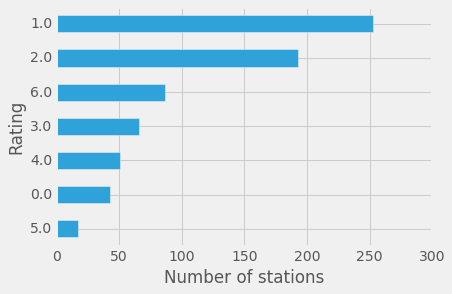

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
df['rating'].value_counts().plot(kind='barh', label='Yolool').invert_yaxis()
plt.ylabel('Rating')
plt.xlabel('Number of stations')


print("Most railway stations (more than 250) have a rating of 1 or 2:")

These are the most frequented stations, in average daily passengers:


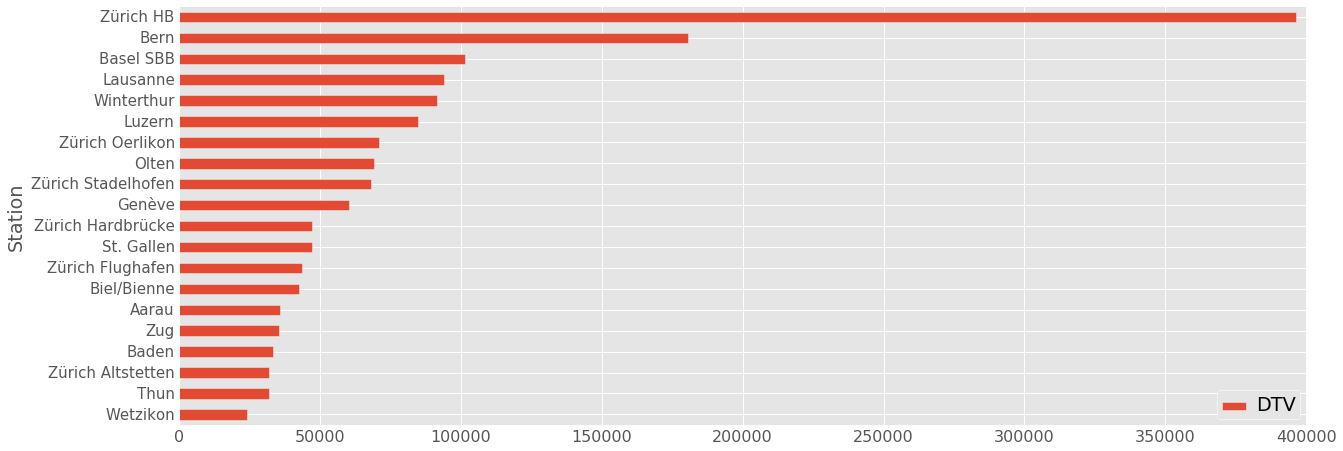

In [92]:
plt.style.use('ggplot')
most_frequented.plot(kind='barh', x='Station', y='DTV').invert_yaxis()

fig = plt.gcf()
fig.set_size_inches(18, 7, forward=True)
plt.rcParams.update({'font.size': 16})
plt.rc('ytick', labelsize=14)

print("These are the most frequented stations, in average daily passengers:")

The same stations and their equipment rating:


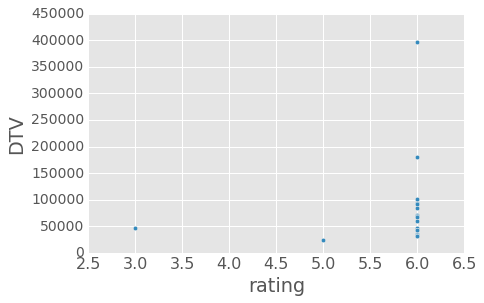

In [93]:
most_frequented.plot(kind='scatter', x='rating', y='DTV')

print("The same stations and their equipment rating:")

